# Transient OAAT CLM6 PPE

# 1. Setup

In [1]:
%load_ext watermark
%load_ext autoreload

import glob
import copy
import pickle

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import cmocean.cm as cmo

import sys
sys.path.append('/glade/u/home/bbuchovecky/projects/cpl_ppe_co2/utils')
import cpl_ppe_co2 as ppe
%aimport cpl_ppe_co2
%autoreload 1

%watermark -iv -co -v

Python implementation: CPython
Python version       : 3.12.10
IPython version      : 9.2.0

conda environment: cpl_ppe_co2

numpy     : 2.0.1
matplotlib: 3.9.1
xarray    : 2025.4.0
cartopy   : 0.24.1
sys       : 3.12.10 | packaged by conda-forge | (main, Apr 10 2025, 22:21:13) [GCC 13.3.0]
cmocean   : 4.0.3
pandas    : 2.2.2



In [2]:
mpl.rcParams['figure.dpi'] = 100

## 1.1. Load ensemble

In [3]:
# Load parameter settings key
key = '/glade/campaign/cgd/tss/projects/PPE/ctsm6_oaat/ctsm6_oaat_key.csv'
df_key = pd.read_csv(key)

# Load parameter colors
with open('./top26_param_colors.pkl', 'rb') as f:
    pscs = pickle.load(f)

In [4]:
# Load postprocessed temporally averaged dataset 
in_file = '/glade/campaign/cgd/tss/projects/PPE/ctsm6_oaat/postp/ctsm6_oaat_postp_1985-2023.nc'
ds_avg = xr.open_dataset(in_file)

# Append key to ds
ds_avg = ds_avg.assign_coords(
    key=('ens', df_key['key'].values),
    param=('ens', df_key['param'].values),
    minmax=('ens', df_key['minmax'].values)
)
ds_avg = ds_avg.set_index(ens=["param", "minmax", "key"], append=True)

# Load postprocessed timeseries dataset
in_file = '/glade/campaign/cgd/tss/projects/PPE/ctsm6_oaat/postp/ctsm6_oaat_postp_timeseries_1901-2023.nc'
ds_tms = xr.open_dataset(in_file)

# Append key to ds
ds_tms = ds_tms.assign_coords(
    key=('ens', df_key['key'].values),
    param=('ens', df_key['param'].values),
    minmax=('ens', df_key['minmax'].values)
)
ds_tms = ds_tms.set_index(ens=["param", "minmax", "key"], append=True)

In [5]:
# Default CLM parameter set
default_avg = ds_avg.isel(ens=0)
default_tms = ds_tms.isel(ens=0)

# Calculate delta from default
ds_avg_delta = ds_avg - default_avg
ds_tms_delta = ds_tms - default_tms

In [6]:
ilamb_dirin = '/glade/work/bbuchovecky/CPL_PPE_CO2/select_parameters/ILAMB_data/processed'
ilamb_zm = xr.open_dataset(f'{ilamb_dirin}/zonal_mean/HFLS_ZONAL_MEAN_ILAMB_2003-2009.nc')['et_itzavg_overlap']
ilamb_gm = {}
for f in glob.glob(ilamb_dirin + '/global_mean/*.nc'):
    key = f.split('/')[-1].split('_')[3]
    ilamb_gm[key] = xr.open_dataset(f)

In [7]:
ilamb_gm['GLEAM']

<xarray.Dataset> Size: 624B
Dimensions:     (year: 39)
Coordinates:
  * year        (year) int64 312B 1980 1981 1982 1983 ... 2015 2016 2017 2018
Data variables:
    hfls_GLEAM  (year) float64 312B ...

Text(0.0, 1.0, 'Transient CLM6 OAAT PPE: EFLX_LH_TOT global mean')

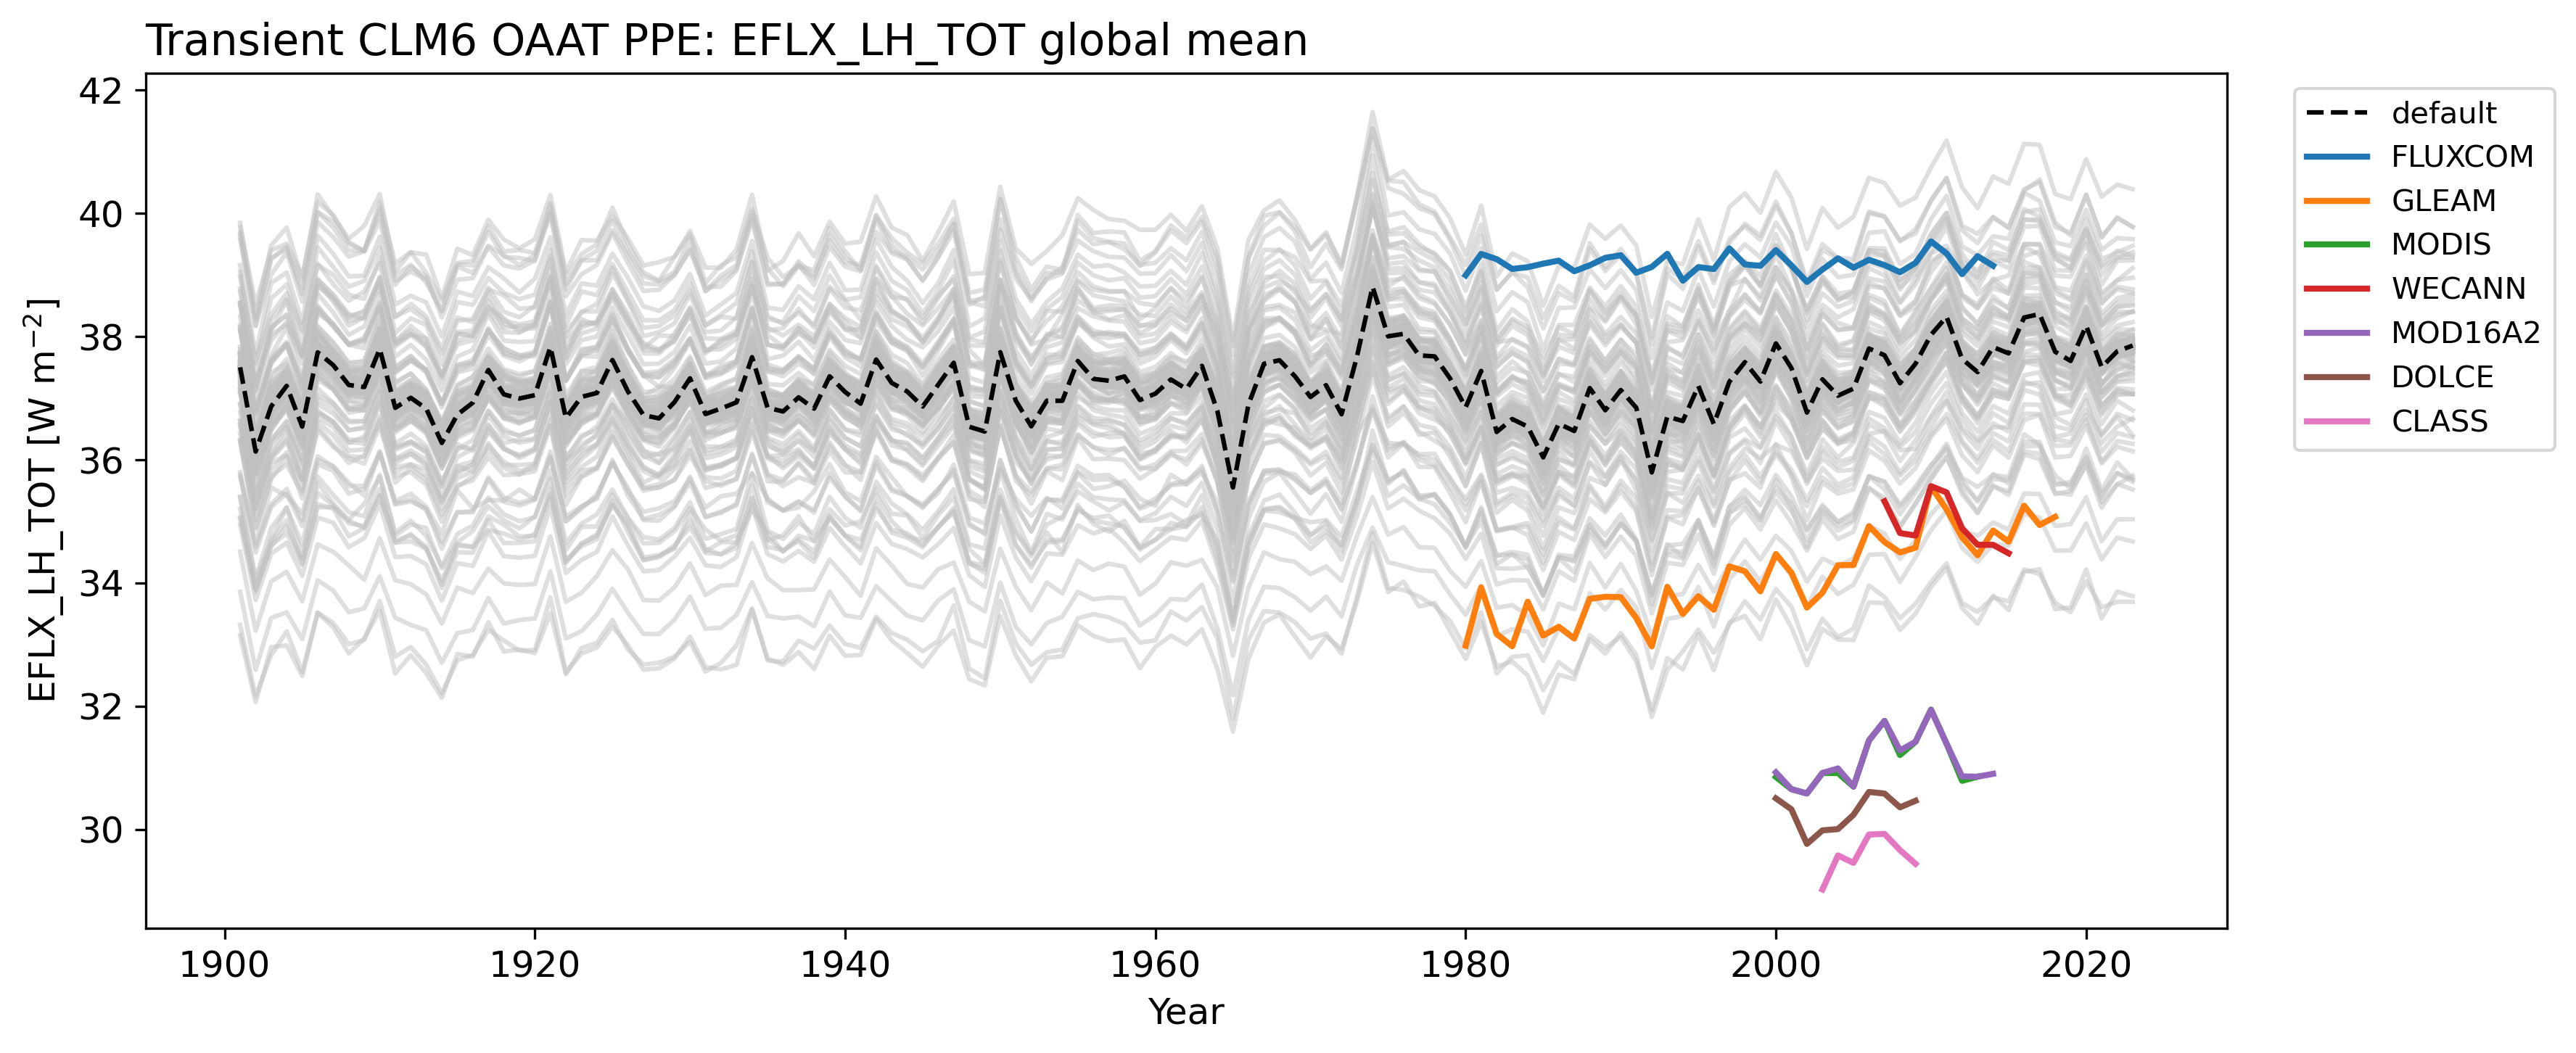

In [10]:
do_colors = False
do_delta = False
do_ilamb = True

ps = [
    'fff',
    # 'jmaxb1',
    'jmaxb0',
    'kmax',
    'medlynslope',
    'medlynintercept',
    'maximum_leaf_wetted_fraction',
    # 'theta_cj',
]

fig, ax = plt.subplots(figsize=(12, 5), layout='tight')
plt.rcParams.update({'font.size': 12, 'axes.labelsize': 12, 'legend.fontsize': 10, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'figure.dpi': 300})

for e in ds_tms_delta.ens:
    if do_delta:
        ds_tms_delta['EFLX_LH_TOT_global_mean'].sel(ens=e).plot(ax=ax, color='silver', alpha=0.5, lw=1.5)
    if not do_delta:
        ds_tms['EFLX_LH_TOT_global_mean'].sel(ens=e).plot(ax=ax, color='silver', alpha=0.5, lw=1.5)
    
if do_colors:
    cs = ppe.get_discrete_colors('jet', len(ps))
    for i, p in enumerate(ps):
        for mm in ['min', 'max']:
            lb = None
            if mm == 'min':
                lb = p
            if do_delta:
                ds_tms_delta['EFLX_LH_TOT_global_mean'].sel(param=p, minmax=mm).plot(ax=ax, color=pscs[p], alpha=0.85, lw=2.5, label=lb)
            if not do_delta:
                ds_tms['EFLX_LH_TOT_global_mean'].sel(param=p, minmax=mm).plot(ax=ax, color=pscs[p], alpha=0.85, lw=2.5, label=lb)

if do_delta:
    ax.axhline(0, c='k', ls=(0, (5, 10)), lw=mpl.rcParams['axes.linewidth'])
    ppe.symmetric_axlim(ax, 'y')

if not do_delta:
    ds_tms['EFLX_LH_TOT_global_mean'].sel(param='default', minmax='max').plot(ax=ax, color='k', ls='--', label='default')

if do_ilamb:
    for key in ilamb_gm.keys():
        ilamb_gm[key]['hfls_'+key].plot(ax=ax, lw=2, label=key)

ax.legend(bbox_to_anchor=(1.025, 1), loc='upper left')
ax.set_ylabel('EFLX_LH_TOT [W m$^{-2}$]')
ax.set_xlabel('Year')
ax.set_title('')
ax.set_title('Transient CLM6 OAAT PPE: EFLX_LH_TOT global mean', loc='left')

# if do_delta and do_colors:
#     fig.savefig('./transient_clm6/EFLX_LH_TOT_global_mean_delta_timeseries.png', dpi=300, bbox_inches='tight')
# if not do_delta and do_colors:
#     fig.savefig('./transient_clm6/EFLX_LH_TOT_global_mean_timeseries.png', dpi=300, bbox_inches='tight')
# if do_delta and not do_colors:
#     fig.savefig('./transient_clm6/EFLX_LH_TOT_global_mean_delta_timeseries_gray.png', dpi=300, bbox_inches='tight')
# if not do_delta and not do_colors:
#     fig.savefig('./transient_clm6/EFLX_LH_TOT_global_mean_timeseries_gray.png', dpi=300, bbox_inches='tight')